<a href="https://colab.research.google.com/github/MrigeeshAshwin/AudioNet/blob/main/fixed_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
dataset_path = "/content/drive/MyDrive/DCASE dataset/"
os.listdir(dataset_path)

['metadata of test set.csv', 'metadata of train set .csv', 'train', 'test']

In [ ]:
train_path = os.path.join(dataset_path, "train/")
test_path = os.path.join(dataset_path, "test/")
# os.listdir(train_path)

## Dataset exploration

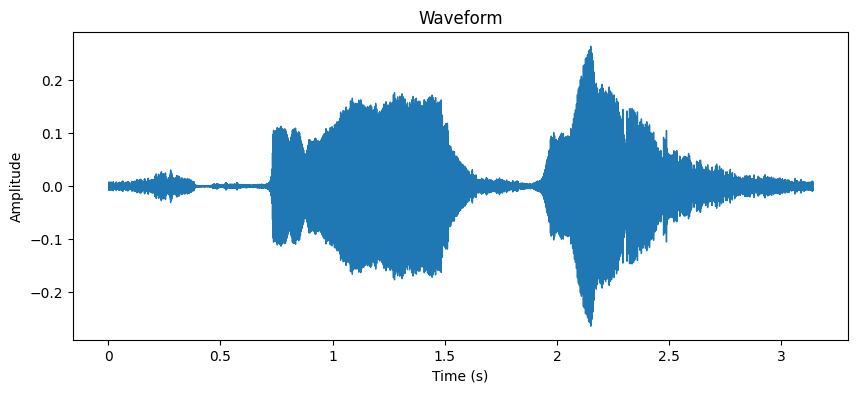

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio


file_path = os.path.join(train_path, "1-man yawn-aigei_6_0.wav")  # Change to an actual file

# Load audio file
y, sr = librosa.load(file_path, sr=None)

# Plot waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()


In [ ]:
Audio(file_path)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

metadata_train_path = os.path.join(dataset_path, "metadata of train set .csv")
df = pd.read_csv(metadata_train_path)

# Display the first few rows
print(df.head())


           Filename File ID  Duration in ms  Class ID Classname  \
0  108160-1_0_0.wav  108160            3730         0    breath   
1  108160-2_0_0.wav  108160            4000         0    breath   
2  108160-3_0_0.wav  108160            4000         0    breath   
3  108160-4_0_0.wav  108160            2226         0    breath   
4  146769-1_0_0.wav  146769            3540         0    breath   

   augmentation  id Augmentation  type                  source  
0                 0            Orignal  https://freesound.org/  
1                 0            Orignal  https://freesound.org/  
2                 0            Orignal  https://freesound.org/  
3                 0            Orignal  https://freesound.org/  
4                 0            Orignal  https://freesound.org/  


In [ ]:
df = df.drop(columns=[df.columns[5], df.columns[6], df.columns[7]])

In [ ]:
df.head()

Filename File ID  Duration in ms  Class ID Classname
0  108160-1_0_0.wav  108160            3730         0    breath
1  108160-2_0_0.wav  108160            4000         0    breath
2  108160-3_0_0.wav  108160            4000         0    breath
3  108160-4_0_0.wav  108160            2226         0    breath
4  146769-1_0_0.wav  146769            3540         0    breath

In [ ]:
class_dict = dict(df[['Class ID', 'Classname']].drop_duplicates().values)
print(class_dict)

{0: 'breath', 1: 'cough', 2: 'crying', 3: 'laugh', 4: 'screaming', 5: 'sneeze', 6: 'yawn'}


In [ ]:
max_duration = np.max(df['Duration in ms'])
max_duration

4000

In [ ]:
df_unique = df.drop_duplicates(subset=['Class ID','Classname'])
print(df_unique)

                         Filename     File ID  Duration in ms  Class ID  \
0                108160-1_0_0.wav      108160            3730         0   
1690    101-cough-aigei-1_1_0.wav         101            3570         1   
2322        100=216491-13_2_0.wav  100=216491            2130         2   
4113            101259-11_3_0.wav      101259            4000         3   
5246  1-screaming-aigei-1_4_0.wav           1            3290         4   
5839       1-sneeze-aigei_5_0.wav           1            2444         5   
6075     1-man yawn-aigei_6_0.wav           1            3140         6   

      Classname  
0        breath  
1690      cough  
2322     crying  
4113      laugh  
5246  screaming  
5839     sneeze  
6075       yawn  


In [ ]:
df.groupby("Classname")["Filename"].count()

Classname
breath       1690
cough         632
crying       1791
laugh        1133
screaming     593
sneeze        236
yawn          214
Name: Filename, dtype: int64

In [ ]:
for dirname, _, filenames in os.walk(train_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/DCASE dataset/train/k8fI3Kkm3GM-258_0_0.wav
/content/drive/MyDrive/DCASE dataset/train/k8fI3Kkm3GM-260_0_0.wav
/content/drive/MyDrive/DCASE dataset/train/k8fI3Kkm3GM-237_0_0.wav
/content/drive/MyDrive/DCASE dataset/train/k8fI3Kkm3GM-251_0_0.wav
/content/drive/MyDrive/DCASE dataset/train/k8fI3Kkm3GM-232_0_0.wav
/content/drive/MyDrive/DCASE dataset/train/k8fI3Kkm3GM-243_0_0.wav
/content/drive/MyDrive/DCASE dataset/train/k8fI3Kkm3GM-236_0_0.wav
/content/drive/MyDrive/DCASE dataset/train/k8fI3Kkm3GM-254_0_0.wav
/content/drive/MyDrive/DCASE dataset/train/k8fI3Kkm3GM-230_0_0.wav
/content/drive/MyDrive/DCASE dataset/train/k8fI3Kkm3GM-24_0_0.wav
/content/drive/MyDrive/DCASE dataset/train/k8fI3Kkm3GM-239_0_0.wav
/content/drive/MyDrive/DCASE dataset/train/k8fI3Kkm3GM-241_0_0.wav
/content/drive/MyDrive/DCASE dataset/train/k8fI3Kkm3GM-240_0_0.wav
/content/drive/MyDrive/DCASE dataset/train/k8fI3Kkm3GM-233_0_0.wav
/content/drive/MyDrive/DCASE dataset/train/k8fI3Kkm3GM-250_0_0.

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import random
import os
from IPython.display import Audio, display  # For audio playback in Jupyter/Colab

def pick_and_plot(file_list, target_classes=["cough", "sneeze", "yawn", "screaming", "crying", "breath", "laugh"], sr=32000):
    # ---------- Filter Files ----------
    filtered = [f for f in file_list if any(cls in f.lower() for cls in target_classes)]
    if not filtered:
        print("No matching files found.")
        return

    file_path = random.choice(filtered)
    selected_class = next((cls for cls in target_classes if cls in file_path.lower()), "unknown")
    print(f"\n🎧 Selected File: {os.path.basename(file_path)}")
    print(f"📌 Detected Class: {selected_class.capitalize()}")

    # ---------- Load Audio ----------
    y, _ = librosa.load(file_path, sr=sr)
    duration = librosa.get_duration(y=y, sr=sr)
    print(f"🕒 Duration: {duration:.2f} sec")

    # ---------- Audio Playback ----------
    display(Audio(file_path))

    # ---------- Feature Extraction ----------
    stft = np.abs(librosa.stft(y))
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)

    # ---------- Plotting ----------
    plt.figure(figsize=(18, 12))
    plt.suptitle(f"Feature Visualization for Class: {selected_class.capitalize()}", fontsize=16)

    plt.subplot(3, 2, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title("Waveform")

    plt.subplot(3, 2, 2)
    librosa.display.specshow(librosa.amplitude_to_db(stft, ref=np.max), sr=sr, y_axis='log', x_axis='time')
    plt.title("Spectrogram (STFT)")
    plt.colorbar(format="%+2.0f dB")

    plt.subplot(3, 2, 3)
    librosa.display.specshow(mel_spec_db, x_axis='time', y_axis='mel', sr=sr)
    plt.title("Mel Spectrogram (dB)")
    plt.colorbar(format="%+2.0f dB")

    plt.subplot(3, 2, 4)
    librosa.display.specshow(mfccs, x_axis='time')
    plt.title("MFCC")
    plt.colorbar()

    plt.subplot(3, 2, 5)
    librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', sr=sr)
    plt.title("Chroma")
    plt.colorbar()

    plt.subplot(3, 2, 6)
    times = librosa.frames_to_time(range(len(spec_centroid[0])), sr=sr)
    plt.semilogy(times, spec_centroid[0], label='Spectral Centroid')
    plt.xlabel('Time (s)')
    plt.ylabel('Hz')
    plt.title("Spectral Centroid Over Time")
    plt.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [ ]:
def get_wav_paths(root_dir, filter_keywords=None):
    wav_paths = []

    for root, _, files in os.walk(root_dir):
        for f in files:
            if f.endswith(".wav"):
                full_path = os.path.join(root, f)
                if filter_keywords:
                    if any(keyword.lower() in full_path.lower() for keyword in filter_keywords):
                        wav_paths.append(full_path)
                else:
                    wav_paths.append(full_path)

    return wav_paths


🎧 Selected File: k8fI3Kkm3GM-1244_0_0.wav
📌 Detected Class: C
🕒 Duration: 4.00 sec


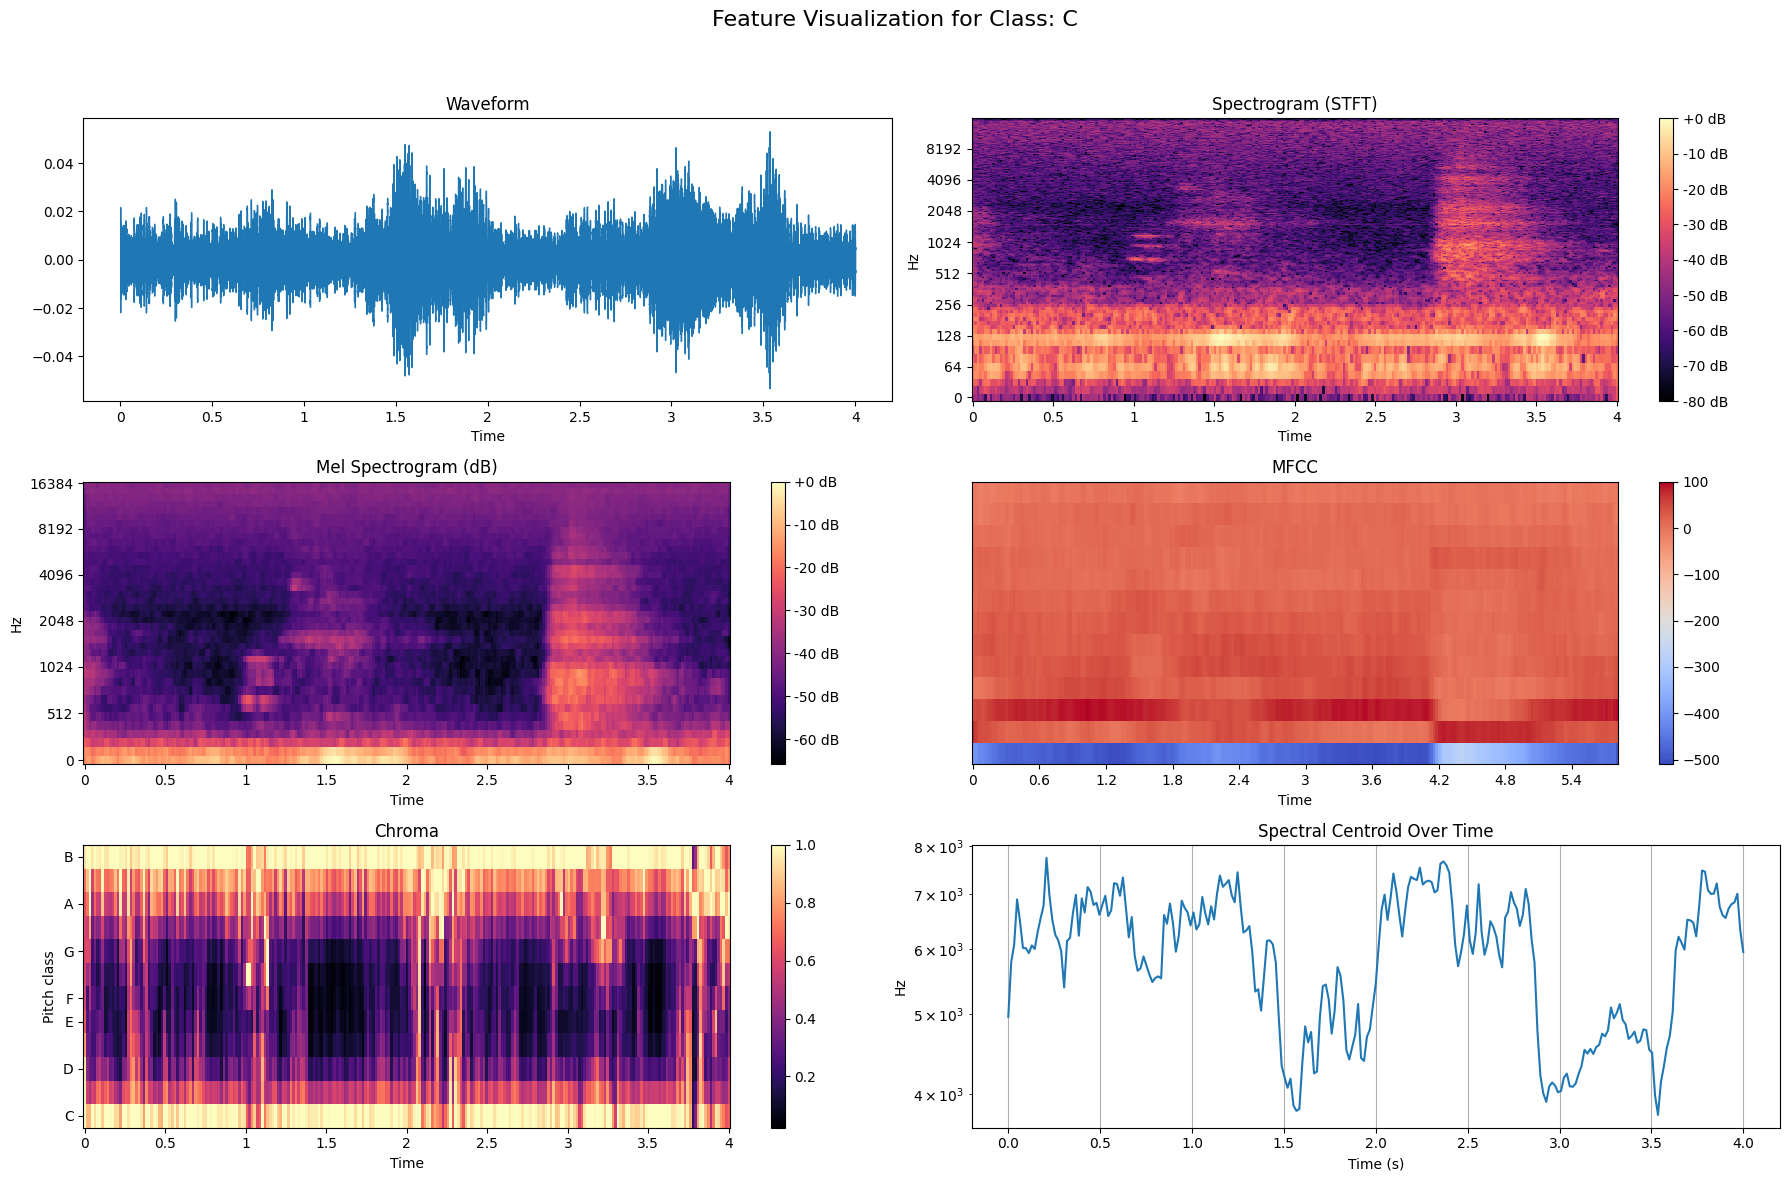


🎧 Selected File: k8fI3Kkm3GM-1485_0_0.wav
📌 Detected Class: Y
🕒 Duration: 4.00 sec


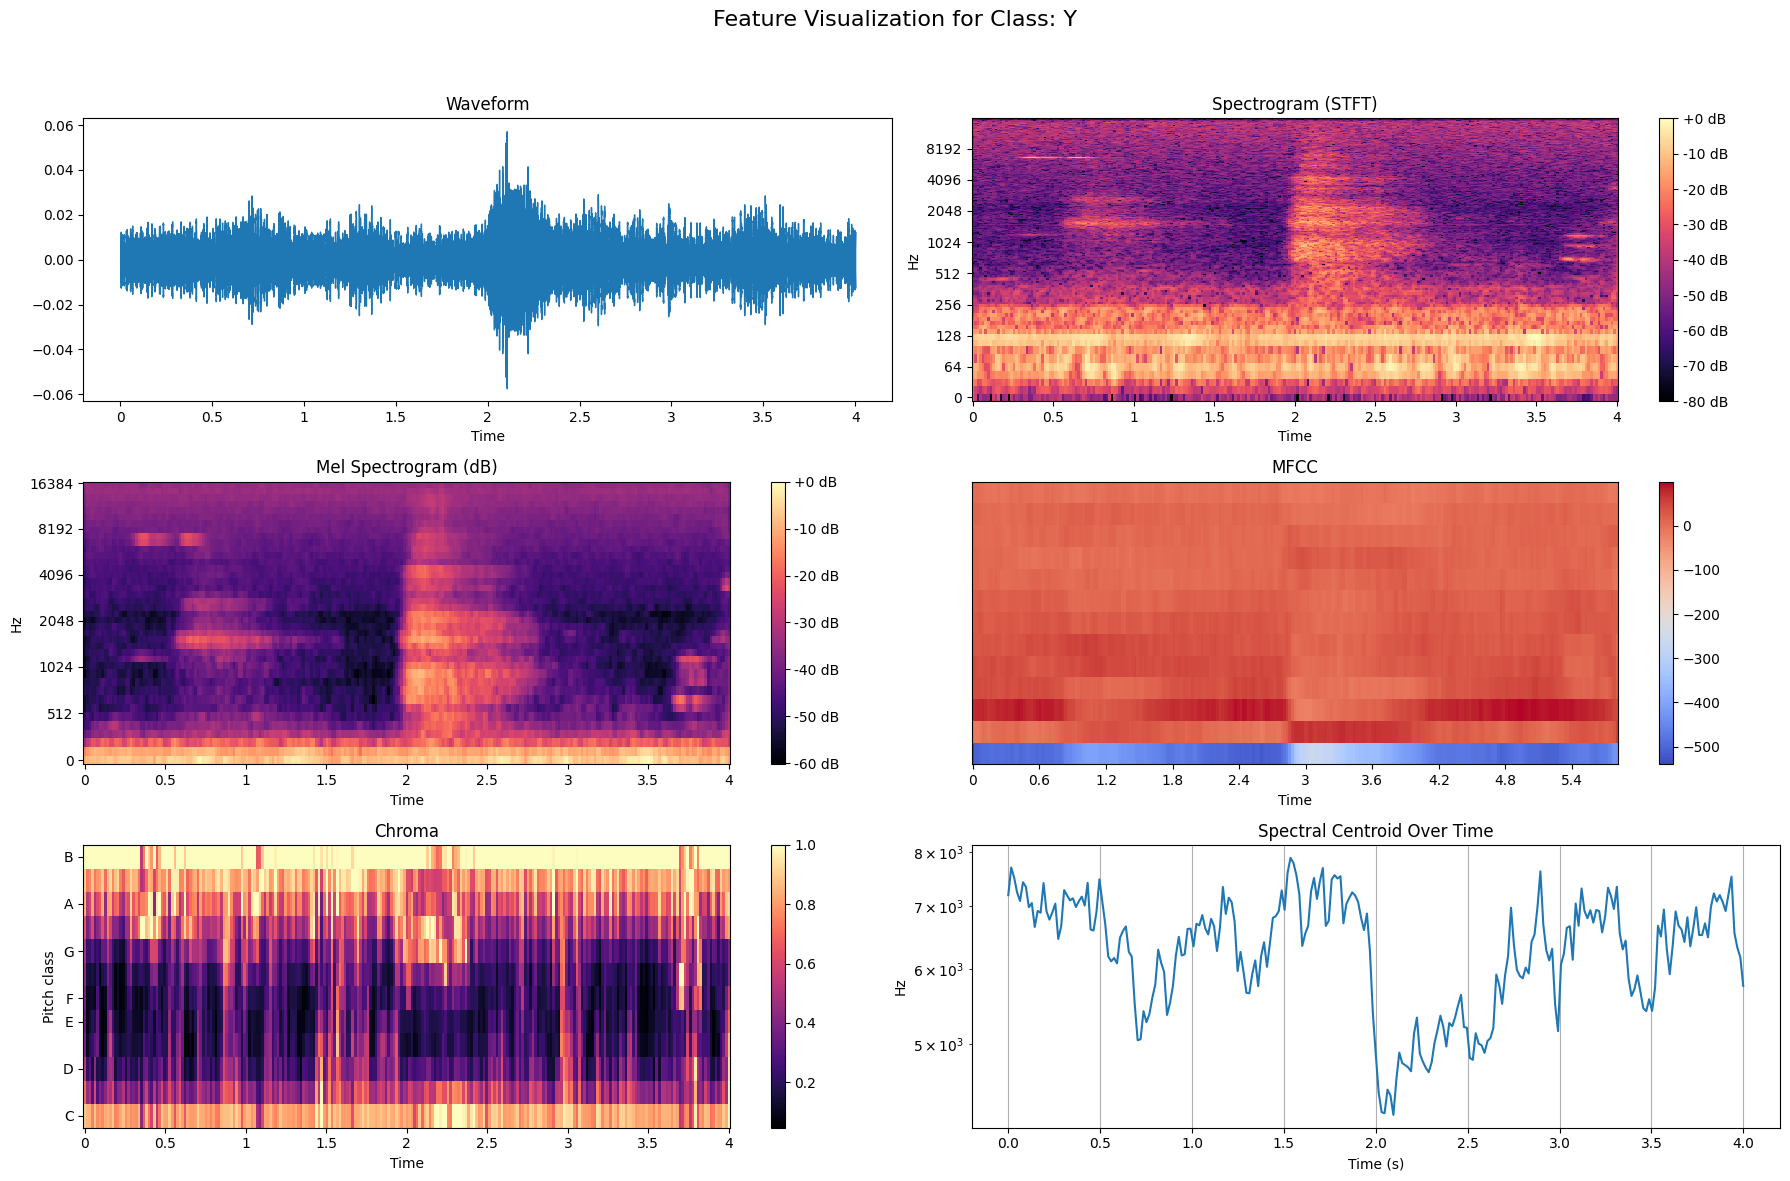


🎧 Selected File: 44884-8_3_0.wav
📌 Detected Class: S
🕒 Duration: 1.52 sec


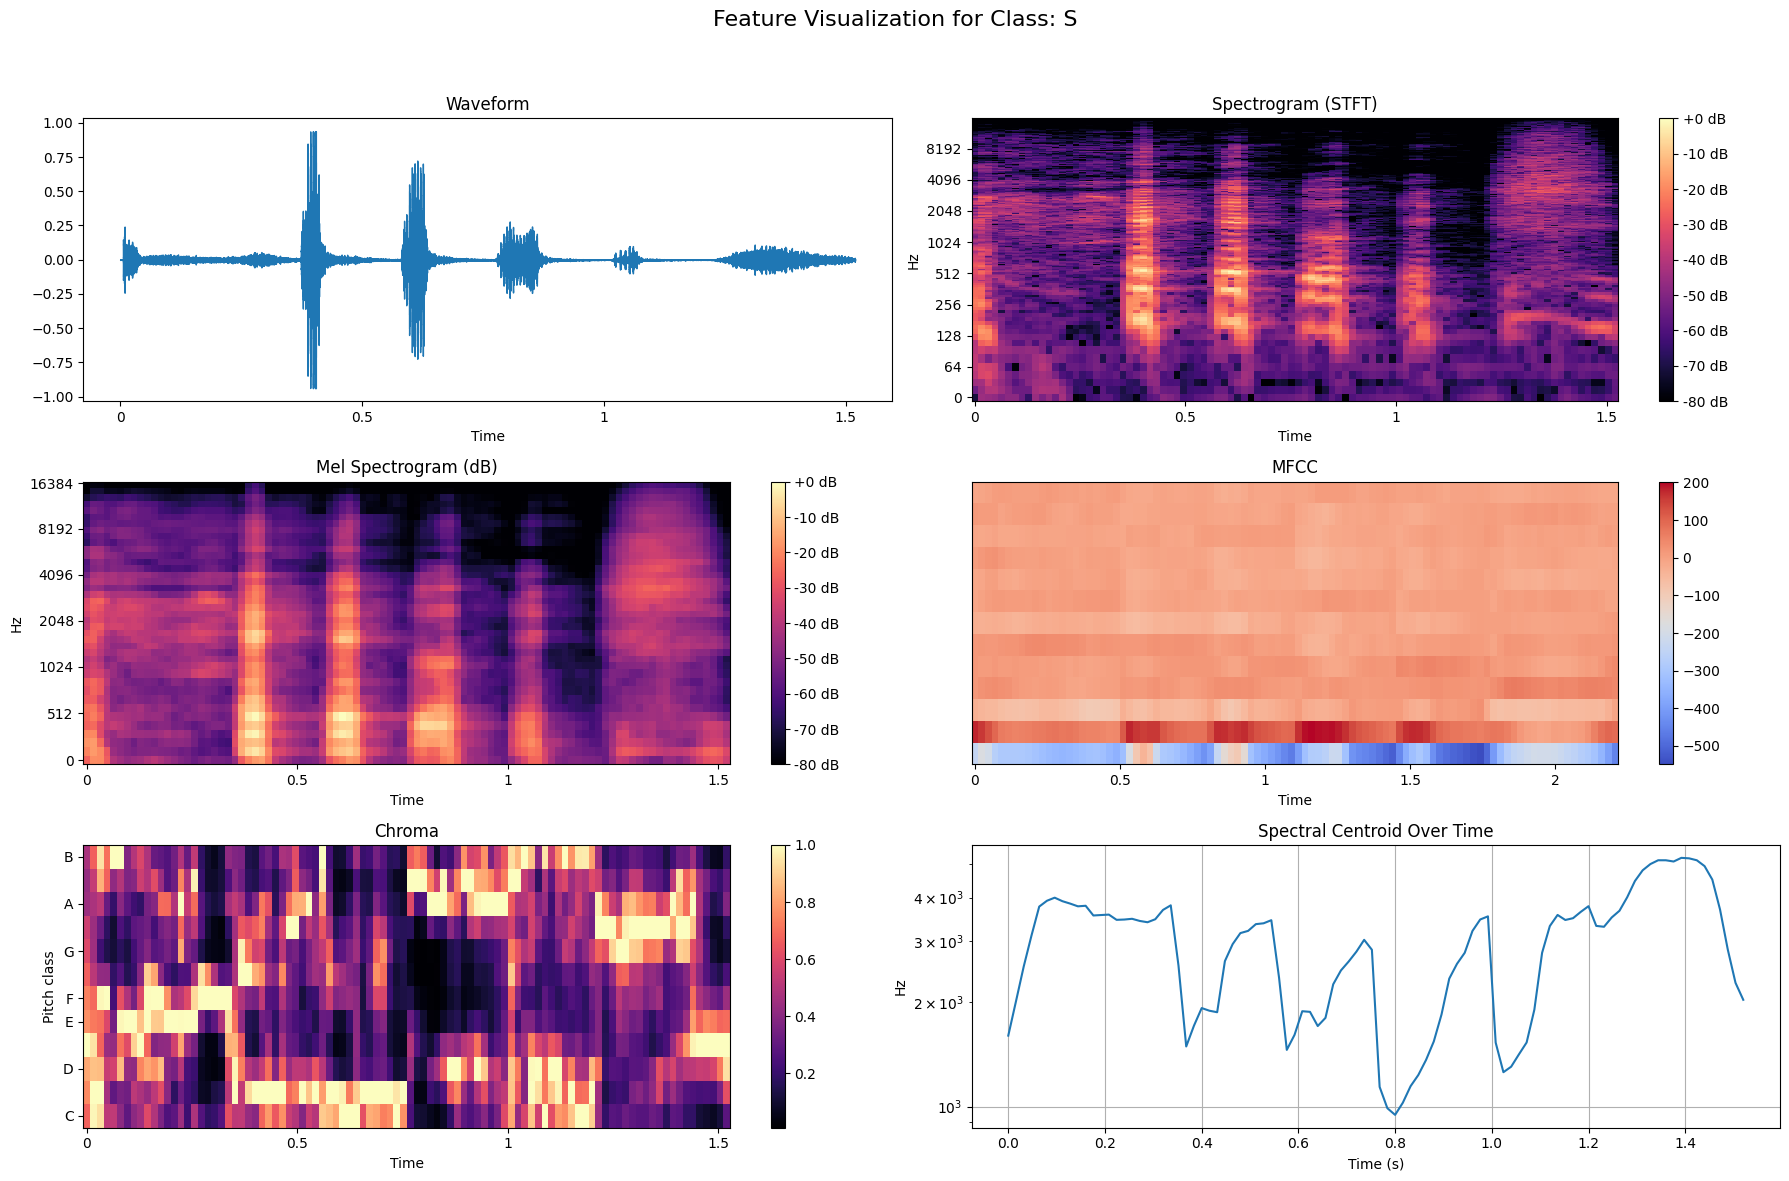


🎧 Selected File: k8fI3Kkm3GM-484_0_0.wav
📌 Detected Class: S
🕒 Duration: 4.00 sec


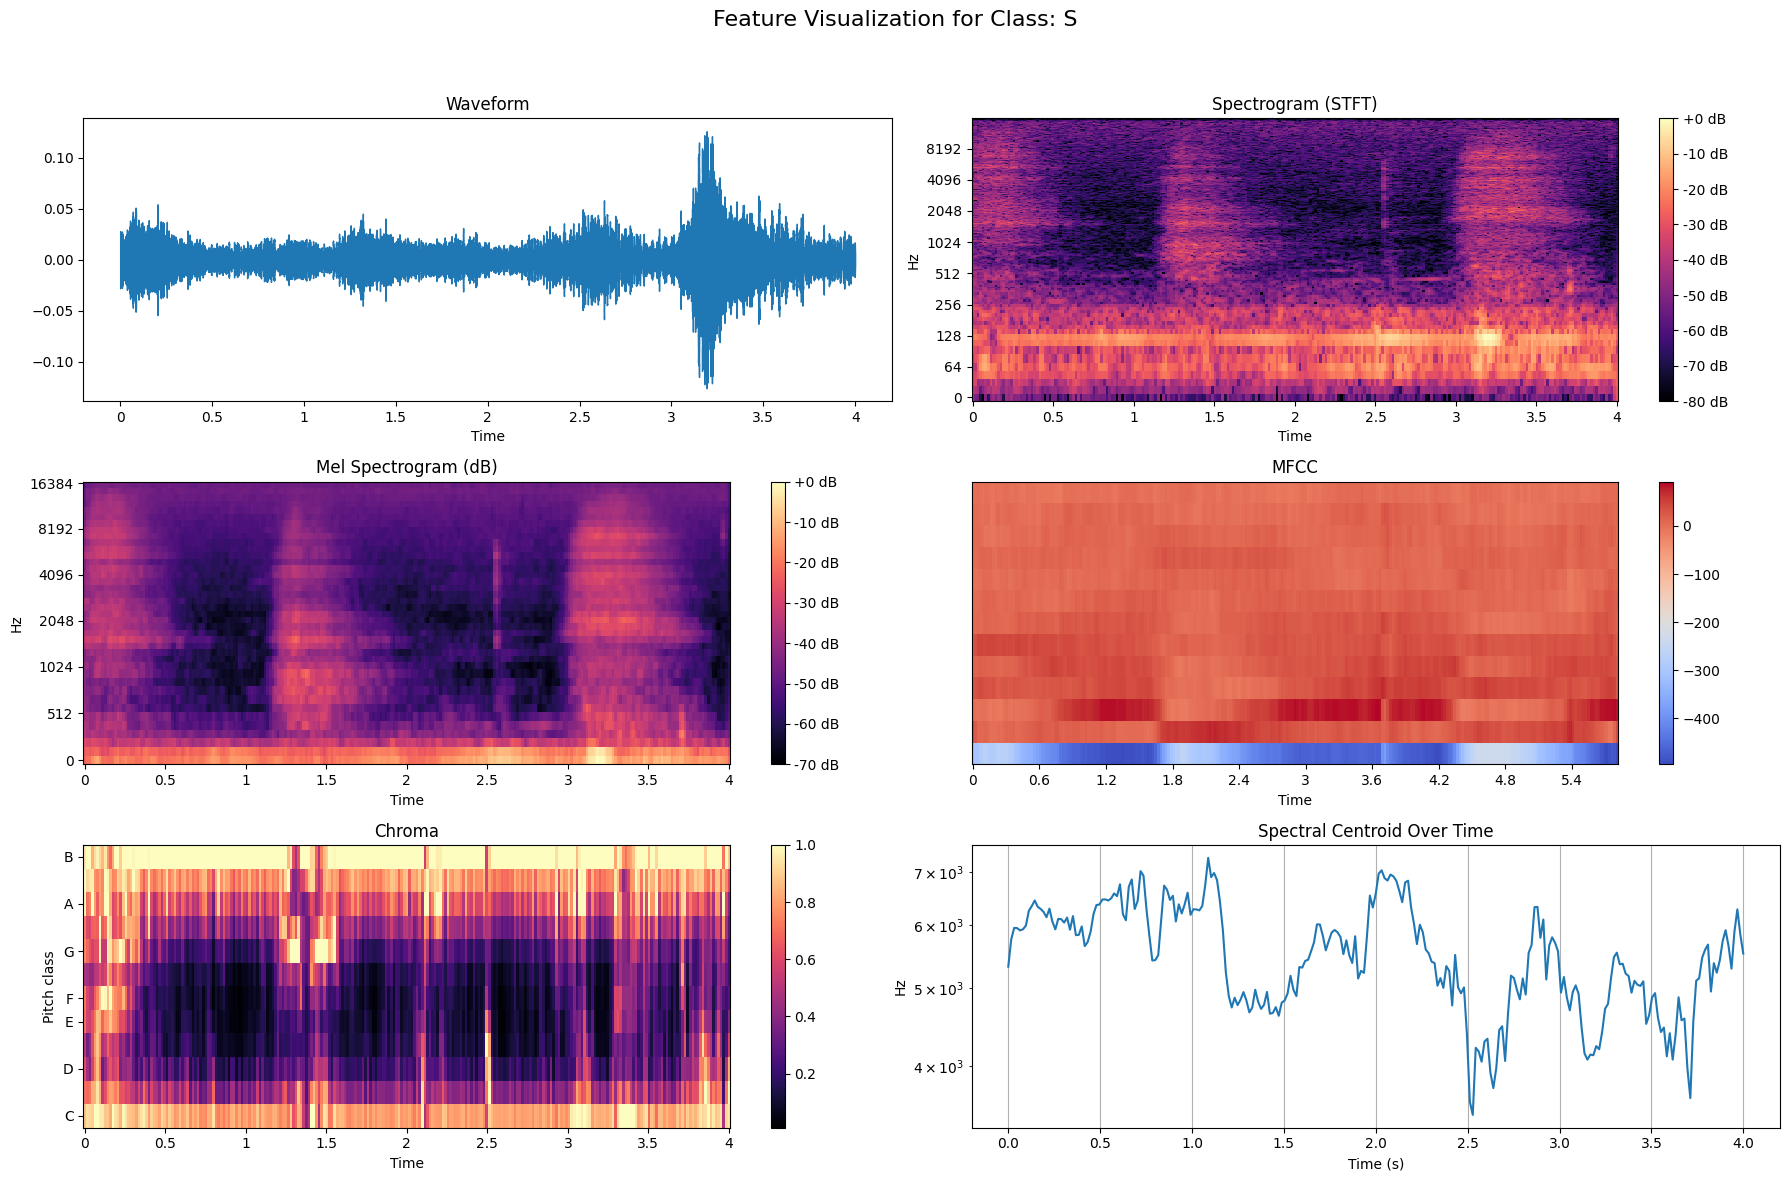


🎧 Selected File: oL2B-AAnsHo-38_2_0.wav
📌 Detected Class: C
🕒 Duration: 4.00 sec


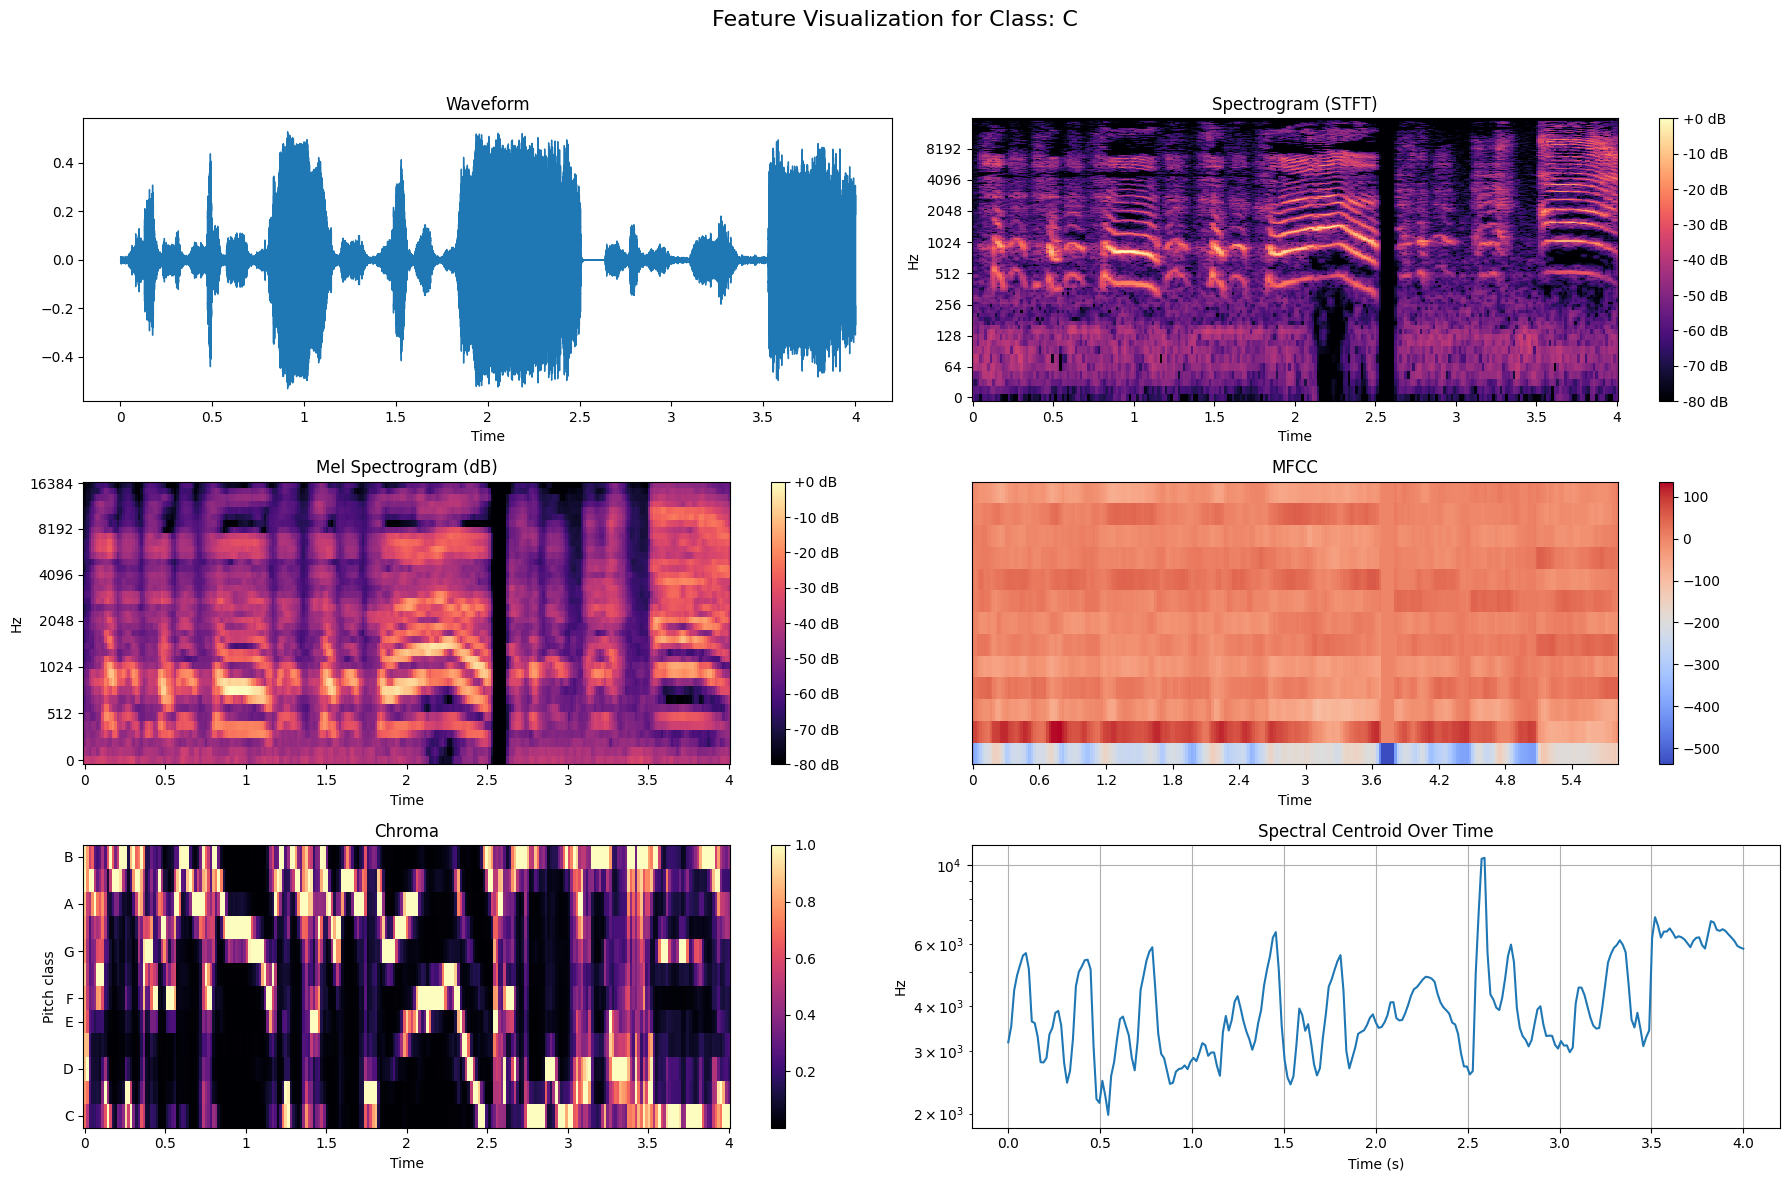


🎧 Selected File: 742=KKKId0LDwVc-365_2_0.wav
📌 Detected Class: R
🕒 Duration: 3.66 sec


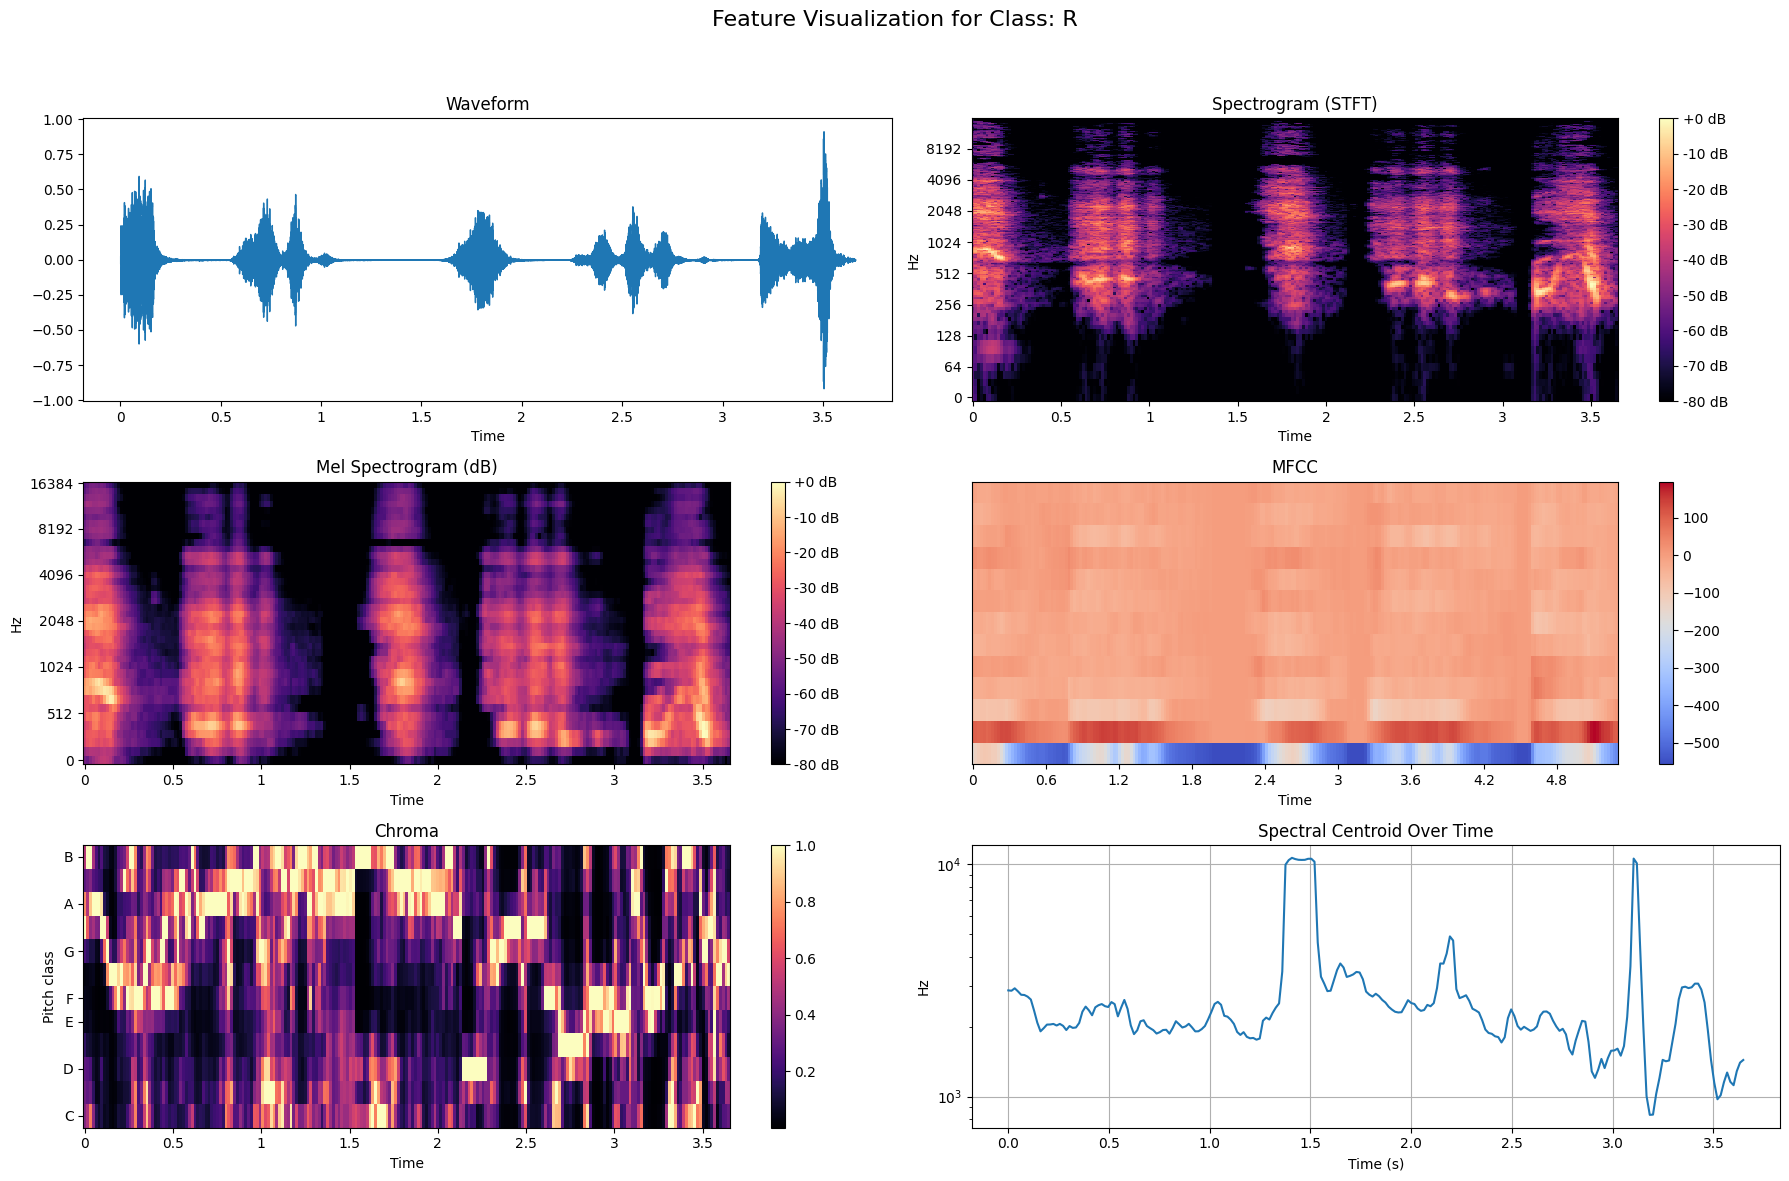


🎧 Selected File: 37-cough-aigei-1_1_0.wav
📌 Detected Class: A
🕒 Duration: 3.79 sec


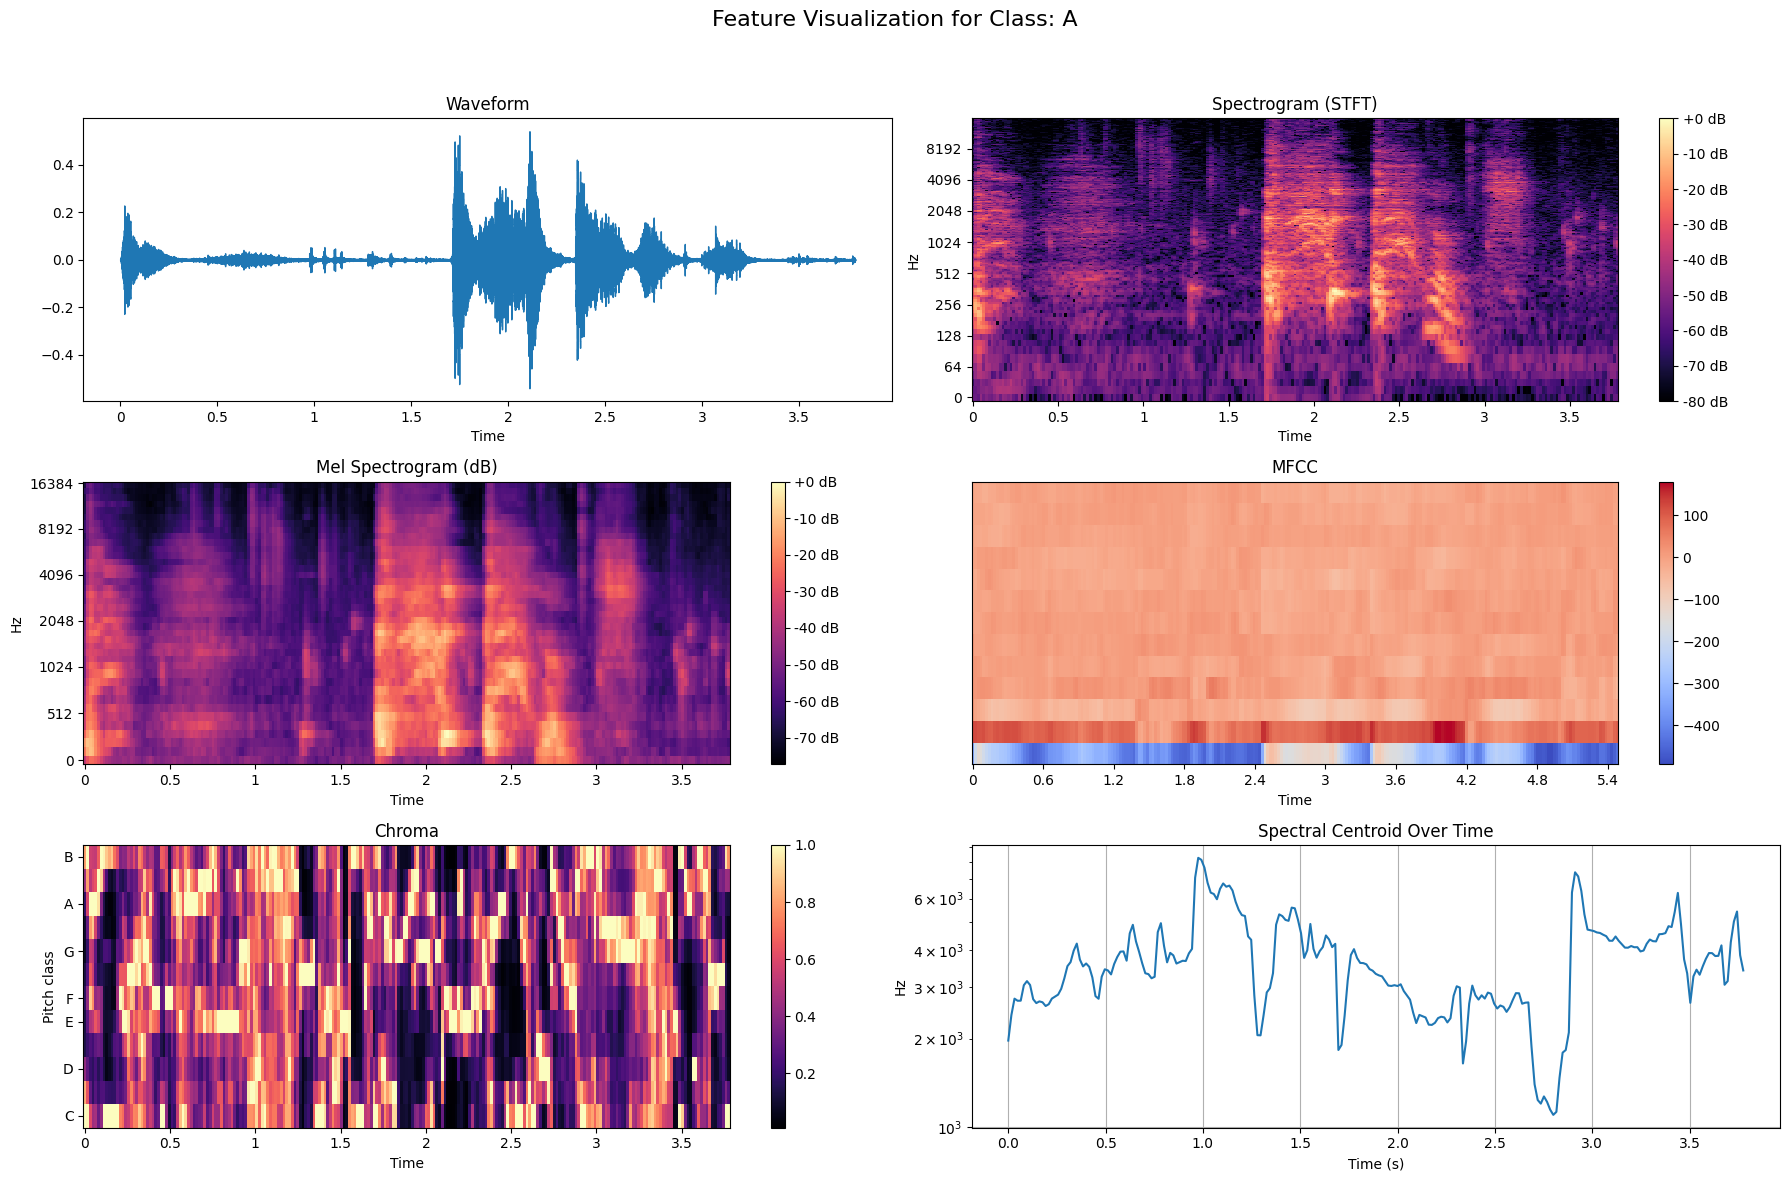

In [ ]:
# Use it like this:
train_data = get_wav_paths("/content/drive/MyDrive/DCASE dataset/train")
pick_and_plot(train_data, "cough")
pick_and_plot(train_data, "yawn")
pick_and_plot(train_data, "sneeze")
pick_and_plot(train_data, "screaming")
pick_and_plot(train_data, "crying")
pick_and_plot(train_data, "breath")
pick_and_plot(train_data, "laugh")

## Feature extraction and augmentation of minority data imparting a balacned nature



In [ ]:
import random  # Make sure this is imported

def time_stretch(audio, rate=1.2):
    return librosa.effects.time_stretch(y=audio, rate=rate)

def pitch_shift(audio, sr, n_steps=2):
    return librosa.effects.pitch_shift(y=audio, sr=sr, n_steps=n_steps)

def add_noise(audio, noise_level=0.005):
    return audio + noise_level * np.random.randn(len(audio))

def change_volume(audio, gain_factor=1.5):
    return audio * gain_factor


In [ ]:
def extract_features(file_path, max_pad_len=128, augment=False):
    try:
        # Load audio
        audio, sr = librosa.load(file_path, sr=32000)

        # Apply augmentations
        if augment:
            original_length = len(audio)  # Store original length before augmentation
            if random.random() < 0.5:
                # print("Applying time stretch")
                audio = time_stretch(audio, rate=random.uniform(0.8, 1.2))
                # audio = librosa.util.fix_length(audio, original_length)  # Keep original length

            if random.random() < 0.5:
                # print("Applying pitch shift")
                audio = pitch_shift(audio, sr, n_steps=random.randint(-2, 2))

            if random.random() < 0.5:
                # print("Adding noise")
                audio = add_noise(audio, noise_level=random.uniform(0.001, 0.005))

            if random.random() < 0.5:
                # print("Changing volume")
                audio = change_volume(audio, gain_factor=random.uniform(0.8, 1.2))

        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        mfccs = (mfccs - np.mean(mfccs)) / np.std(mfccs)  # Normalize

        # Pad or truncate MFCCs
        if mfccs.shape[1] < max_pad_len:
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, max_pad_len - mfccs.shape[1])), mode='constant')
        else:
            mfccs = mfccs[:, :max_pad_len]

        return mfccs.T  # Transpose for LSTM compatibility

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


## Loading of training data


In [ ]:
from tqdm.auto import tqdm
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Extract file paths and labels
audio_file_name = df['Filename'].tolist()
labels = df["Classname"].tolist()
class_ids = df["Class ID"].values

# Feature extraction with progress bar
X = np.array([extract_features(f"/content/drive/MyDrive/DCASE dataset/train/{file}") for file in tqdm(audio_file_name, desc="Extracting Features")])

print(f"✅ Feature extraction completed! Shape: {X.shape}")

Extracting Features:   0%|          | 0/6289 [00:00<?, ?it/s]

✅ Feature extraction completed! Shape: (6289, 128, 40)


In [ ]:
sound_labels = {"breath": 0, "cough": 1, "crying": 2, "laugh": 3, "screaming": 4, "sneeze": 5, "yawn": 6}


## Augmentation of Minority data


In [ ]:
from collections import Counter

# Count current samples per class
class_counts = Counter(df['Classname'])
max_count = max(class_counts.values())  # 1791 (max samples for 'crying')

# Store augmented data
augmented_data = []

for classname, count in class_counts.items():
    files = df[df['Classname'] == classname]['Filename'].tolist()

    # Number of additional samples needed
    num_augmentations = max_count - count

    print(f"Augmenting {classname}: Need {num_augmentations} more samples...")

    for _ in tqdm(range(num_augmentations)):
        file_path = random.choice(files)
        features = extract_features(f"/content/drive/MyDrive/DCASE dataset/train/{file_path}", augment=True)
        if features is not None:
            augmented_data.append((features, classname))

# Convert to NumPy Arrays
X_augmented = np.array([x[0] for x in augmented_data])
y_augmented = np.array([x[1] for x in augmented_data])

# Add to Original Data
X_balanced = np.concatenate((X, X_augmented), axis=0)


Augmenting breath: Need 101 more samples...


  0%|          | 0/101 [00:00<?, ?it/s]

Augmenting cough: Need 1159 more samples...


  0%|          | 0/1159 [00:00<?, ?it/s]

Augmenting crying: Need 0 more samples...


0it [00:00, ?it/s]

Augmenting laugh: Need 658 more samples...


  0%|          | 0/658 [00:00<?, ?it/s]

Augmenting screaming: Need 1198 more samples...


  0%|          | 0/1198 [00:00<?, ?it/s]

Augmenting sneeze: Need 1555 more samples...


  0%|          | 0/1555 [00:00<?, ?it/s]

Augmenting yawn: Need 1577 more samples...


  0%|          | 0/1577 [00:00<?, ?it/s]

In [ ]:
# one hot encoding for unaugmented data
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(df["Classname"])  # Apply on all data
# One-Hot Encode
y_one_hot = to_categorical(y_encoded)

# Convert string labels to numeric values using the dictionary
y_augmented_encoded = np.array([sound_labels[label] for label in y_augmented])

# Convert to one-hot encoding
y_augmented_one_hot = to_categorical(y_augmented_encoded, num_classes=len(sound_labels))

y_balanced_one_hot = np.concatenate((y_one_hot, y_augmented_one_hot), axis=0)

# Final Balanced Data
y_balanced = np.array(y_balanced_one_hot)  # Now in one-hot format

print("Balanced dataset shape:", X_balanced.shape, y_balanced.shape)


Balanced dataset shape: (12537, 128, 40) (12537, 7)


In [ ]:
# Encode labels correctly
num_classes = 7  # Adjust based on actual number of classes
y= to_categorical(y_balanced.argmax(axis=1), num_classes=num_classes)
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
X_balanced.shape

(12537, 128, 40, 1)

## Building, training and testing the model

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# used a single model
def build_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 40, 1)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(7, activation='softmax')  # 7 Classes
    ])

    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# K-Fold Cross-Validation (3 folds)
kf = KFold(n_splits=3, shuffle=True, random_state=42)

fold = 1
all_reports = []

for train_idx, val_idx in kf.split(X_balanced):  # No need for y_balanced since data is balanced
    print(f"\n Fold {fold}: Training & Evaluating...")

    # Split Data
    X_train, X_val = X_balanced[train_idx], X_balanced[val_idx]
    y_train, y_val = y_balanced[train_idx], y_balanced[val_idx]

    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]

    # Build Model
    model = build_cnn_model()

    # Train Model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=10, batch_size=32, verbose=1)

    # Predict
    y_pred_probs = model.predict(X_val)
    y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels
    y_true = np.argmax(y_val, axis=1)  # Convert one-hot labels back to class labels

    # Compute Metrics
    report = classification_report(y_true, y_pred, target_names=sound_labels.keys(), output_dict=True)

    # Store Report
    all_reports.append(report)

    # Display Report for the Fold
    print(f"\n Classification Report for Fold {fold}:\n")
    print(classification_report(y_true, y_pred, target_names=sound_labels.keys()))

    fold += 1



 Fold 1: Training & Evaluating...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 116s 426ms/step - accuracy: 0.4218 - loss: 1.8627 - val_accuracy: 0.2795 - val_loss: 2.5674
Epoch 2/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 118s 449ms/step - accuracy: 0.6400 - loss: 1.0011 - val_accuracy: 0.4984 - val_loss: 1.4570
Epoch 3/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 140s 441ms/step - accuracy: 0.7173 - loss: 0.7683 - val_accuracy: 0.7540 - val_loss: 0.7229
Epoch 4/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 132s 404ms/step - accuracy: 0.7931 - loss: 0.5659 - val_accuracy: 0.8117 - val_loss: 0.5535
Epoch 5/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 150s 433ms/step - accuracy: 0.8376 - loss: 0.4778 - val_accuracy: 0.8043 - val_loss: 0.5806
Epoch 6/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 136s 412ms/step - accuracy: 0.8684 - loss: 0.3671 - val_accuracy: 0.8301 - val_loss: 0.5603
Epoch 7/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 152s 449ms/step - accuracy: 0.8993 - loss: 0.2911 - val_accuracy: 0.8339 - val_loss: 0.5524
Epoch 8/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 138s 433ms/step - accuracy: 0.8983 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 109s 401ms/step - accuracy: 0.4291 - loss: 1.7512 - val_accuracy: 0.2649 - val_loss: 6.7496
Epoch 2/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 152s 438ms/step - accuracy: 0.6322 - loss: 1.0270 - val_accuracy: 0.5968 - val_loss: 1.3221
Epoch 3/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 133s 407ms/step - accuracy: 0.7201 - loss: 0.7581 - val_accuracy: 0.7717 - val_loss: 0.6478
Epoch 4/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 152s 446ms/step - accuracy: 0.7829 - loss: 0.5958 - val_accuracy: 0.7949 - val_loss: 0.5704
Epoch 5/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 136s 422ms/step - accuracy: 0.8225 - loss: 0.5120 - val_accuracy: 0.7624 - val_loss: 0.6882
Epoch 6/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 137s 404ms/step - accuracy: 0.8506 - loss: 0.4091 - val_accuracy: 0.8337 - val_loss: 0.4952
Epoch 7/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 152s 441ms/step - accuracy: 0.8898 - loss: 0.3186 - val_accuracy: 0.8394 - val_loss: 0.5355
Epoch 8/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 132s 403ms/step - accuracy: 0.9033 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 120s 447ms/step - accuracy: 0.4436 - loss: 1.7419 - val_accuracy: 0.1713 - val_loss: 4.9349
Epoch 2/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 140s 437ms/step - accuracy: 0.6556 - loss: 0.9604 - val_accuracy: 0.6844 - val_loss: 0.8607
Epoch 3/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 133s 406ms/step - accuracy: 0.7391 - loss: 0.7256 - val_accuracy: 0.7270 - val_loss: 0.8407
Epoch 4/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 115s 437ms/step - accuracy: 0.7823 - loss: 0.5937 - val_accuracy: 0.7832 - val_loss: 0.7182
Epoch 5/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 133s 404ms/step - accuracy: 0.8318 - loss: 0.4731 - val_accuracy: 0.8031 - val_loss: 0.6275
Epoch 6/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 141s 401ms/step - accuracy: 0.8658 - loss: 0.3790 - val_accuracy: 0.8318 - val_loss: 0.5653
Epoch 7/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 142s 404ms/step - accuracy: 0.8890 - loss: 0.3074 - val_accuracy: 0.7746 - val_loss: 0.7802
Epoch 8/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 142s 404ms/step - accuracy: 0.9046 -

In [ ]:
# Aggregate Results Across Folds
average_f1 = np.mean([r['weighted avg']['f1-score'] for r in all_reports])
average_precision = np.mean([r['weighted avg']['precision'] for r in all_reports])
average_recall = np.mean([r['weighted avg']['recall'] for r in all_reports])

print("\n **Final Cross-Validation Scores:**")
print(f" Average F1-score: {average_f1:.4f}")
print(f" Average Precision: {average_precision:.4f}")
print(f" Average Recall: {average_recall:.4f}")



 **Final Cross-Validation Scores:**
 Average F1-score: 0.8482
 Average Precision: 0.8596
 Average Recall: 0.8479


#Testing on unseen data

In [ ]:
test_df = pd.read_csv("/content/drive/MyDrive/DCASE dataset/metadata of test set.csv")  # Modify this if your test data is in a different format

# Extract features from test audio files
X_test = np.array([extract_features(f"/content/drive/MyDrive/DCASE dataset/test/{file}") for file in tqdm(test_df["Filename"], desc="Processing Test Data")])

print(f"Test Data Shape: {X_test.shape}")


Processing Test Data:   0%|          | 0/725 [00:00<?, ?it/s]

Test Data Shape: (725, 128, 40)


In [ ]:
y_test = np.array([
    sound_labels["yawn"] if label == "yawm" else sound_labels[label]
    for label in test_df["Classname"]
])
y_test_one_hot = to_categorical(y_test, num_classes=len(sound_labels))  # One-hot encode

In [ ]:
X_test = np.expand_dims(X_test, axis=-1)  # New shape: (725, 128, 40, 1)

In [ ]:
# X_test = np.squeeze(X_test, axis=-1)  # Removes the last extra dimension
X_test.shape

(725, 128, 40, 1)

In [ ]:
# Should match training shape
test_loss, test_acc = model.evaluate(X_test, y_test_one_hot)
print(f" Test Accuracy: {test_acc:.4f}")

# Generate Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert softmax probabilities to class index
y_true_classes = np.argmax(y_test_one_hot, axis=1)

# Classification Report
from sklearn.metrics import classification_report
print("\n Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=sound_labels.keys()))


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.6018 - loss: 1.3497
 Test Accuracy: 0.6745
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step

 Classification Report:
              precision    recall  f1-score   support

      breath       0.87      0.57      0.69       160
       cough       0.62      0.57      0.59        70
      crying       0.76      0.70      0.73       205
       laugh       0.71      0.71      0.71       140
   screaming       0.75      0.83      0.79        70
      sneeze       0.22      0.77      0.34        30
        yawn       0.74      0.70      0.72        50

    accuracy                           0.67       725
   macro avg       0.67      0.69      0.65       725
weighted avg       0.74      0.67      0.69       725



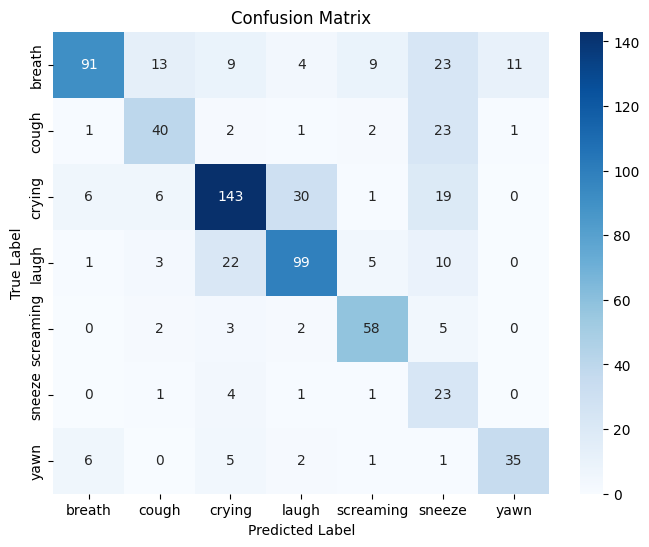

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Define class labels (should match your dataset labels)
class_labels = list(sound_labels.keys())  # Assuming sound_labels is your label mapping dictionary

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import f1_score

f1_macro = f1_score(y_true_classes, y_pred_classes, average='macro')  # Unweighted mean across classes
f1_weighted = f1_score(y_true_classes, y_pred_classes, average='weighted')  # Weighs by class frequency

print("Overall Macro F1-Score:", f1_macro)
print("Overall Weighted F1-Score:", f1_weighted)


Overall Macro F1-Score: 0.6529780780883573
Overall Weighted F1-Score: 0.6917626761485619
